In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300

(array([2178.,  618.,  326.,  253.,  214.,  260.,  141.,  195.,   92.,
         86.]), array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]), <a list of 10 Patch objects>)


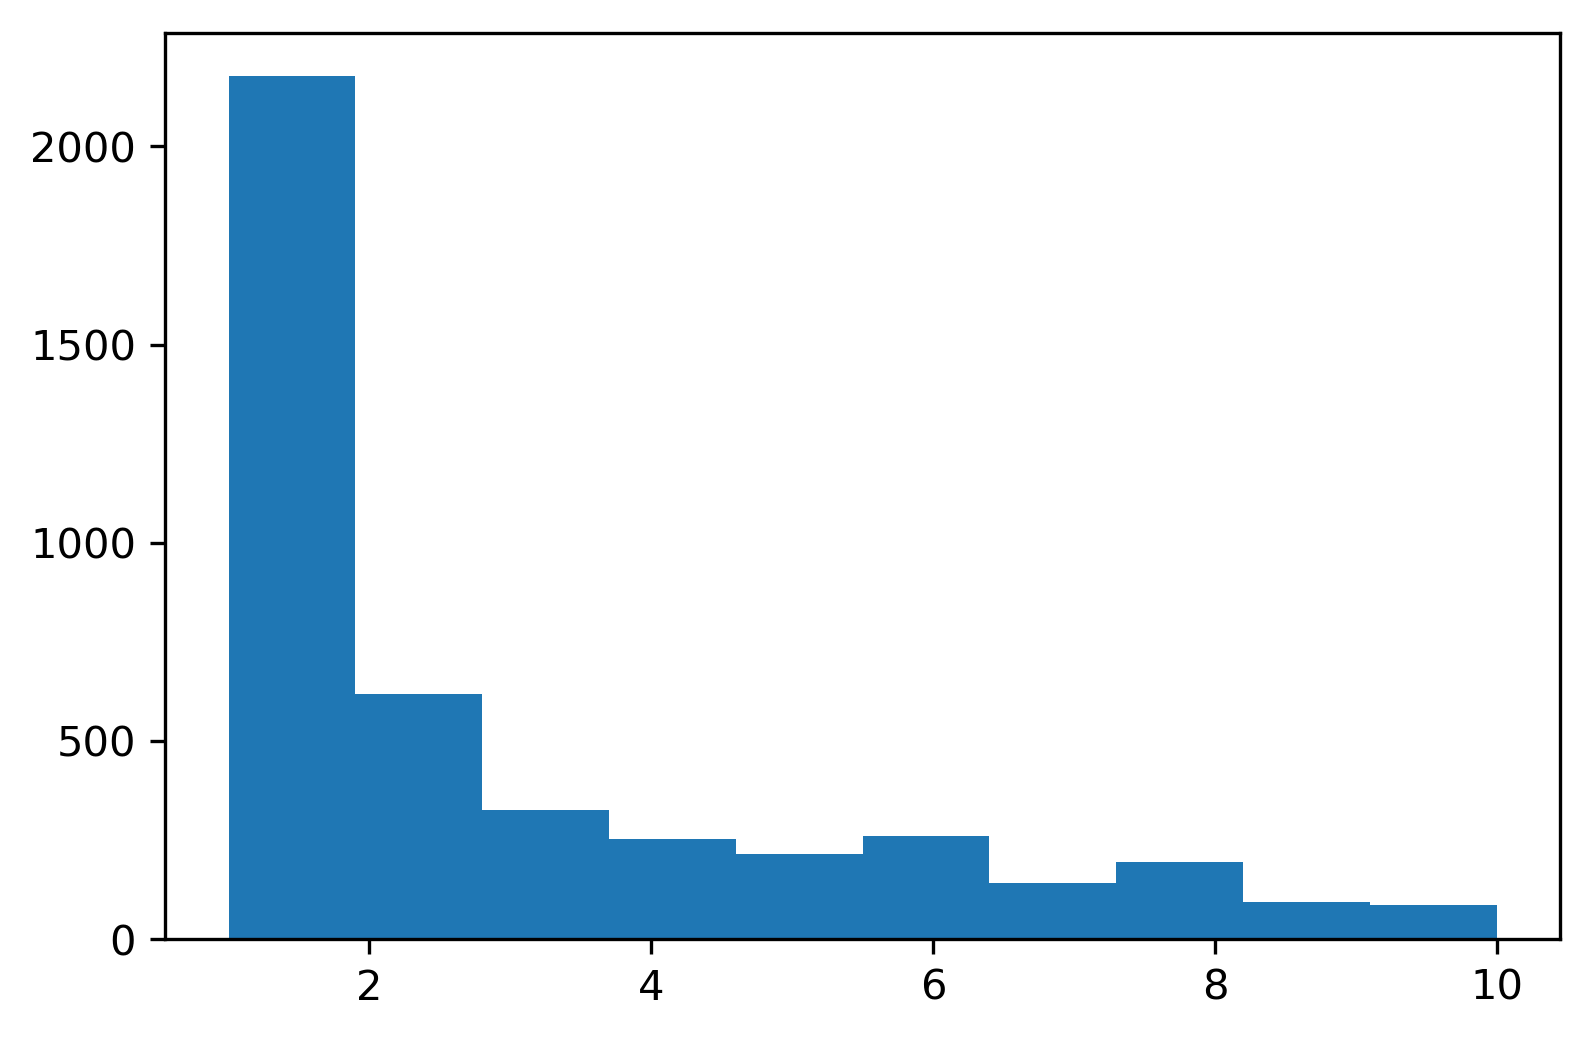

In [3]:
df_data = pd.read_csv("train_data.csv",header=None)
df_labels = pd.read_csv("train_labels.csv",header=None,names=["label"])
print(plt.hist((df_labels.label.values)))


In [4]:
counts = df_labels['label'].value_counts().values
weights = [sum(counts)/(10*count) for count in counts]
weights

[0.20032139577594124,
 0.7059870550161812,
 1.3383435582822085,
 1.678076923076923,
 1.724505928853755,
 2.038785046728972,
 2.237435897435897,
 3.094326241134752,
 4.7423913043478265,
 5.073255813953488]

In [5]:
X = df_data.values
y = df_labels.values
print(X.shape)
print(y.shape)

(4363, 264)
(4363, 1)


In [29]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score,log_loss

def normalize(X):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X)
    return x_scaled

def report(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    cm = cm / cm.astype(np.float).sum(axis=1)
    
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.show()
    print(classification_report(y_test, y_pred))

def clean_data(X):
    rhythm = list(range(24*7))
    chroma = list(range(len(rhythm),len(rhythm)+12*4))
    mfcc = list(range(len(chroma)+len(rhythm),len(chroma)+len(rhythm)+12*4))
    #The first 4 columns of MFCC
    remove = np.array([0,1,2,3])
    remove = np.array([remove+i*12 for i in range(4)])
    remove = remove.flatten()
    remove = np.array(mfcc)[remove]
    clean_data = np.delete(X,remove,axis=1)
    return clean_data

def get_splits(X,labels,test_size=0.4,val_size=0.4,random_state=0,smote=False):

    X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=test_size, random_state=random_state)
    X_train,X_val,y_train,y_val= train_test_split(X_train,y_train, test_size=val_size, random_state=random_state)
    
    if smote ==False:
        return X_train,X_val,X_test,y_train,y_val,y_test
    sm = SMOTEENN(random_state=random_state)
    
    X_res, y_res = sm.fit_resample(X_train, y_train)
    return X_res,X_val,X_test,y_res,y_val,y_test

def compute_pca(Z, d):
    # Input: the N by D data matrix Z, the number of components d
    # Output: a d by D matrix W_pca, and all eigenvalues of Q
    
    N = Z.shape[0]
    Q = 1/N*(Z.T@Z)

    values,vectors = np.linalg.eig(Q)

    sort  = np.argsort(values)
    largest = sort[-d:][::-1]
    W_pca = vectors[:,largest]
    W_pca = W_pca.T
    eigvalues = values
    
    return W_pca.real,eigvalues

def compression(X,PCA,num_dims):
    compr = X @ PCA[:num_dims,:].T
    return compr

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Accuracy')
    plt.legend()
    plt.show()
    
    
def test_nn(X,y,num_epochs=100,batch_size=32,drop_out=0.2,num_neurons=128,cv=False):
    keras.backend.clear_session()
    X_train,X_val,X_test, y_train,y_val,y_test = get_splits(X=X,labels=y,smote=False)
    
    # because tensorflow expects labels from 0-9
    y_train = y_train-1
    y_val = y_val-1
    y_test = y_test-1
    N = X_train.shape[1]
    
    
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation=tf.keras.activations.sigmoid,input_shape=(N,)),
        keras.layers.Dropout(drop_out),
        keras.layers.Dense(num_neurons,activation=tf.keras.activations.relu),
        keras.layers.Dropout(drop_out),
        keras.layers.Dense(10, activation='softmax')
    ])


    
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=num_epochs,batch_size=batch_size,validation_data=(X_val,y_val),verbose=False)

    
    y_pred = model.predict_classes(X_test)
    loss_score = model.evaluate(X_test,y_test)
    if(cv==False):
        print(model.summary())
        plot_history(history)
        print("Score of the model with num_neurons{0} and dropout {1} is : ".format(num_neurons,drop_out),loss_score[1])
        report(y_pred,y_test)
        return model
    
    return history,loss_score


def xgboost(param,data,labels,quite=False,num_rounds=1000):
    X_train,X_val,X_test, y_train,y_val,y_test = get_splits(X=data,labels=labels,smote=False)
    # subtract one to make 0 to 9
    #y_labels = np.eye(10)[y_train-1]
    dtrain = xgb.DMatrix(X_train,label=y_train-1)
    dval = xgb.DMatrix(X_val,label=y_val-1)
    dtest = xgb.DMatrix(X_test,label=y_test-1)
    '''
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softprob'
    # scale weight of positive examples
    param['eta'] = 0.3
    param['max_depth'] = 9
    param['silent'] = 1
    param['num_class'] = 10
    param['eval_metric']=['mlogloss','merror']
    param['reg_lambda']=1
    param['reg_alpha']=0
    param['min_child_weight']=2.8
    '''
    evallist=[(dval,'validation'),(dtest,'test')]
    num_round = 1000
    results ={}
    bst = xgb.train(param, dtrain, num_round,evallist,evals_result=results,early_stopping_rounds=242,verbose_eval=False)
    
    if quite == False:
        print("Best n_tree limit: ",bst.best_ntree_limit)
        print("Best iteration: ",bst.best_iteration)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
        print(bst.eval(dtest,name='testing',iteration=bst.best_iteration))
        y_pred = np.argmax(y_pred,axis=1)
        print(accuracy_score(y_test,y_pred+1))
        report(y_pred+1,y_test)
    
    return results,bst
    

In [30]:
def preprocess(X):
    X_norm = normalize(X)
    PCA,eigvals = compute_pca(X_norm,264)
    X_compress = compression(X_norm,PCA,num_dims=150)
    return X_compress




eta_vals = np.linspace(0.1,1,50)
max_depth_vals = np.arange(1,100,1)
lambda_vals = np.logspace(-4,4,10)
min_child_weight = np.linspace(0,50,50)

X_norm = normalize(X)
lowest_merror=np.inf
cv_data =[]
for max_depth in max_depth_vals:
    for min_child in min_child_weight:
        for lam in lambda_vals:
            for eta in eta_vals:
                param = {}
                # use softmax multi-class classification
                param['objective'] = 'multi:softprob'
                # scale weight of positive examples
                param['eta'] = eta
                    
                param['max_depth'] = max_depth
                param['silent'] = 1
                param['num_class'] = 10
                param['eval_metric']=['mlogloss','merror']
                param['reg_lambda']=lam
                param['reg_alpha']=0
                param['min_child_weight']=min_child
                
                eval_data,clf = xgboost(param=param,data=X_norm,labels=y,quite=True)
                best_merror= clf.best_score
                if(lowest_merror>best_merror):
                    lowest_merror = best_merror
                    print("Best score:{0} eta:{1} depth:{2} lammbda: {3} child_weight:{4} and iteration:{5}".format(best_merror,eta,max_depth,lam,min_child,clf.best_iteration))
                cv_data.append((best_merror,param,clf.best_iteration))
    
print(len(cv_data))

ValueError: Found input variables with inconsistent numbers of samples: [4363, 248]

In [ ]:
import pickle
with open('xgb.pkl','wb') as fp
    pickle.dump(cv_data.fp)


In [31]:
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.1

param['max_depth'] = 10
param['silent'] = 1
param['num_class'] = 10
param['eval_metric']=['mlogloss','merror']
param['reg_lambda']=0.005994842503189409
param['reg_alpha']=0
param['min_child_weight']=4
eval_data,clf=xgboost(param=param,data=normalize(X),labels=y,num_rounds=149)
print(clf.best_score)

ValueError: Found input variables with inconsistent numbers of samples: [4363, 248]

In [22]:
eval_data['test']['merror'][clf.best_iteration]


0.351088

<BarContainer object of 248 artists>

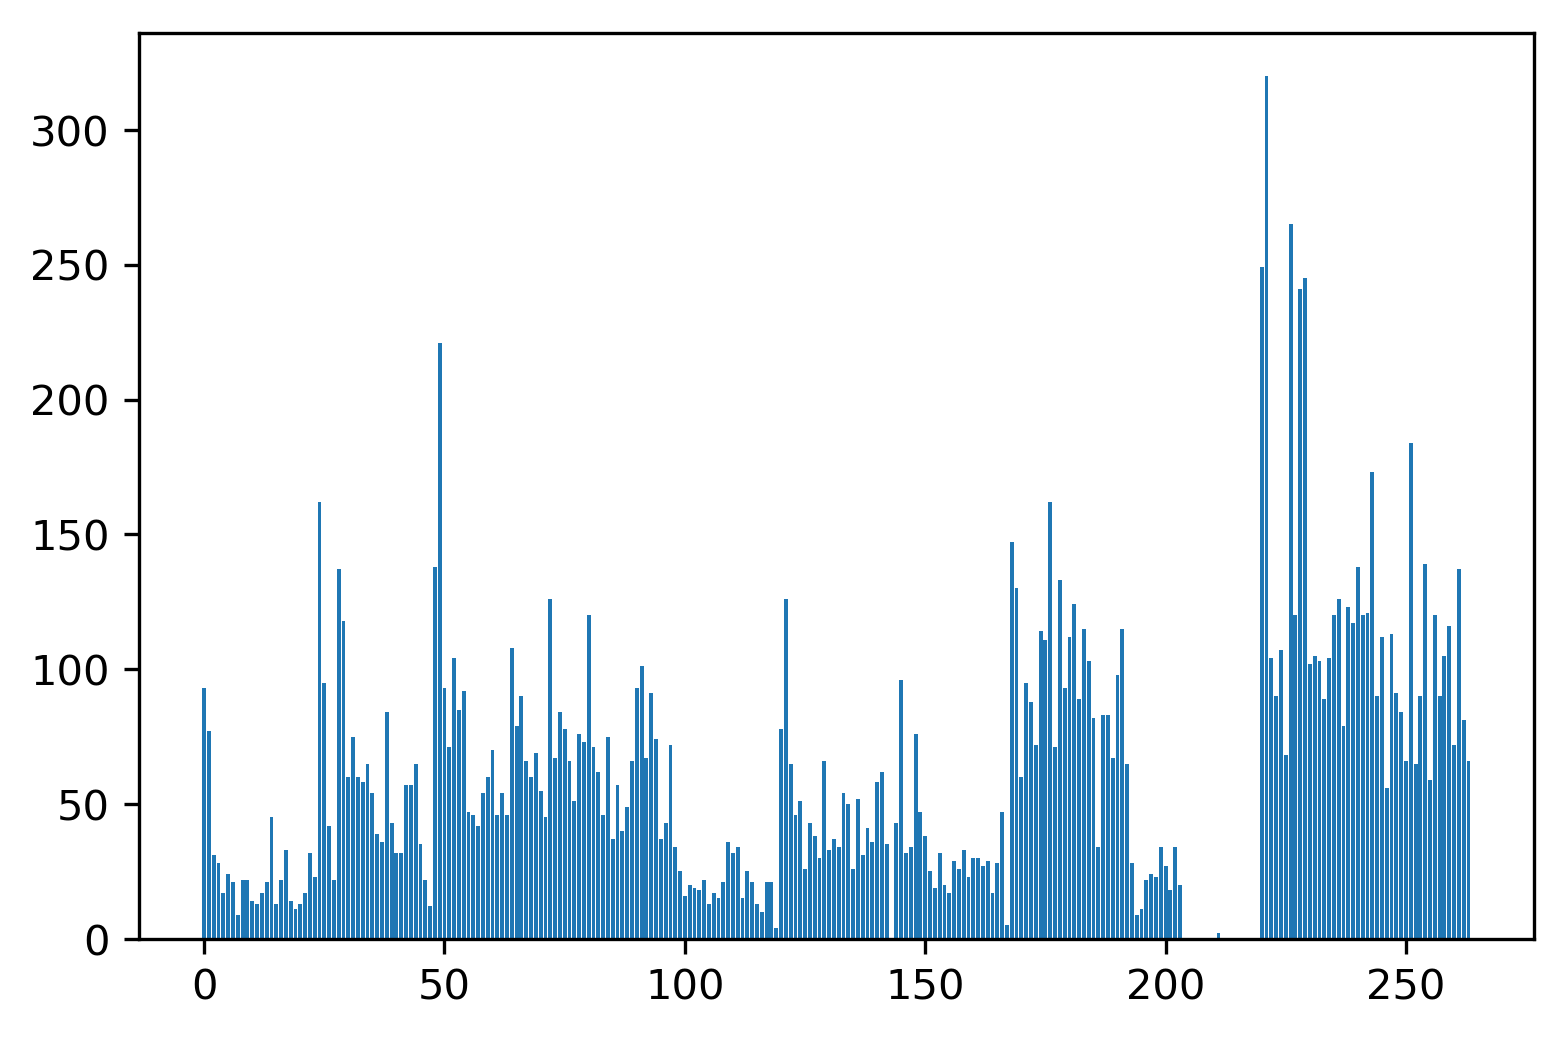

In [23]:
f_scores = clf.get_fscore()
vals = sorted([(int(a[1:]),b) for a,b in f_scores.items()])
x,y = zip(*vals)
plt.bar(x,y)

In [123]:
df_kaggle = pd.read_csv('test_data.csv',header=None)
kaggle = df_kaggle.values

In [124]:
kaggle_norm = normalize(X=kaggle)
#PCA,_ = compute_pca(normalize(X),264)
#kaggle_compress = compression(kaggle_norm,PCA,num_dims=150)
#kaggle_pred = model.predict_classes(kaggle_compress)
mat = xgb.DMatrix(kaggle)
kaggle_pred = clf.predict(mat)
kaggle_pred = np.argmax(kaggle_pred,axis=1)+1
kaggle_pred

array([3, 3, 1, ..., 1, 3, 1], dtype=int64)

In [125]:
best = pd.read_csv('accuracy_solution_29_Oct_3.csv')['Sample_label'].values
best_nn = pd.read_csv('accuracy_solution_26_Oct_1.csv')['Sample_label'].values
for i in range(1,11):
    print("Sum of class {0} for best: {1} and output is {2}".format(i,sum(best==i),sum(kaggle_pred==i)))
print(sum(best==kaggle_pred))

Sum of class 1 for best: 4221 and output is 4328
Sum of class 2 for best: 901 and output is 876
Sum of class 3 for best: 469 and output is 470
Sum of class 4 for best: 281 and output is 242
Sum of class 5 for best: 115 and output is 98
Sum of class 6 for best: 281 and output is 269
Sum of class 7 for best: 23 and output is 20
Sum of class 8 for best: 102 and output is 105
Sum of class 9 for best: 97 and output is 84
Sum of class 10 for best: 54 and output is 52
5790


In [126]:
output = pd.DataFrame()
output['Sample_id'] = range(1,len(kaggle_pred)+1)
output['Sample_label'] = [int(i) for i in kaggle_pred]
output


,Sample_id,Sample_label
0,1,3
1,2,3
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,1


In [127]:
file_name = "accuracy_solution_1_Nov_1.csv"
output.to_csv(file_name,index=False)

In [120]:
preds = clf.predict(mat)
print(preds)

[[2.3201421e-02 1.7990100e-01 7.0009863e-01 ... 1.3394667e-03
  2.2181483e-02 4.8793908e-03]
 [6.0069617e-02 1.2831284e-02 6.8687975e-01 ... 3.6603617e-03
  1.6518791e-01 1.0391028e-02]
 [5.6128794e-01 5.0773001e-03 2.9476450e-03 ... 3.8480750e-01
  1.5434396e-03 3.7358685e-03]
 ...
 [9.5543671e-01 3.4445688e-02 1.3311566e-03 ... 9.3364896e-04
  2.2659320e-04 2.4594173e-03]
 [5.3473385e-03 2.8184107e-02 9.6254945e-01 ... 5.0650066e-04
  1.5245744e-03 3.0298723e-04]
 [8.1164318e-01 1.0183966e-02 7.5789756e-04 ... 6.4556539e-02
  3.3949385e-03 5.0256932e-03]]


In [124]:
kaggle_log_pred = clf.predict(mat)
result_log = pd.DataFrame(data=kaggle_log_pred,columns=['Class_{0}'.format(i) for i in range(1,11)])
result_log['Sample_id'] = result_log.index+1
cols = result_log.columns.tolist()
cols = [cols[-1]]+cols[:-1]
result_log = result_log[cols]
result_log



,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Sample_id
0,0.023201,0.179901,0.700099,0.013158,0.004243,0.023396,0.027601,0.001339,0.022181,0.004879,1
1,0.060070,0.012831,0.686880,0.014536,0.009410,0.033772,0.003262,0.003660,0.165188,0.010391,2
2,0.561288,0.005077,0.002948,0.002097,0.010252,0.025247,0.003004,0.384807,0.001543,0.003736,3
3,0.995278,0.003981,0.000193,0.000033,0.000095,0.000019,0.000134,0.000091,0.000037,0.000138,4
4,0.989191,0.003843,0.000639,0.000193,0.000429,0.001555,0.001834,0.001140,0.000279,0.000897,5
5,0.402643,0.000155,0.001381,0.015357,0.055822,0.158726,0.022086,0.332181,0.002111,0.009539,6
6,0.160705,0.071473,0.060828,0.113680,0.102906,0.101881,0.019019,0.015902,0.152416,0.201190,7
7,0.917536,0.000363,0.000148,0.005152,0.069057,0.000230,0.002602,0.002784,0.000381,0.001748,8
8,0.997521,0.000080,0.000025,0.000020,0.000954,0.000322,0.000241,0.000728,0.000036,0.000073,9
9,0.473097,0.462955,0.015668,0.001372,0.008750,0.003625,0.005797,0.004393,0.020530,0.003812,10


In [82]:
file_name = "logloss_solution_30_Oct_1.csv"
result_log.to_csv(file_name,index=False)